In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [ ]:
data = pd.read_excel('/content/HD_2019_M_2.xlsx')
all_nan = data.columns[data.isnull().sum() == 465].tolist()
data = data.drop(columns = all_nan)

In [ ]:
def age(date):
    date = date.split('/')
    age = 111-int(date[0])
    return age
def treat_year(date):
    date = date.split('/')
    year = 2019-int(date[0])
    return year

In [ ]:
df = data.rename(columns = {'合併症':'comorbidities', '性別':'gender', '離子鈣 (mg/dl)':'Ca', '生日':'birthday', 
    '透析前體重(kg)':'weight', '本次透析時間(min)':'duration', '本次透析前BUN (mg/dl)':'BUN', '兩次透析時間間隔 (min)':'time_interval'})
df['Age'] = df['birthday'].map(age)
df['treatment_year'] = df['開始治療日期'].map(treat_year)
# 合併症因為還不確定空值所以先暫時刪掉，Glucose因為空值太多所以先刪掉, Kt/V (Gotch)適用另一種公式算的先刪掉
df = df.drop(columns = ['本次透析後BUN (mg/dl)', '透析後體重(kg)', '透析器型號', 'PlanDate', 'birthday', '開始治療日期','comorbidities','Glucose[AC] (mg/dl)','Kt/V (Gotch)']) 


In [ ]:
#target_col = [col for col in x.columns if '(' in col]
def trim_column(col,df):
  new_col = col.split(' (')[0]
  df = df.rename(columns = {col:new_col})
  return df
col_list = df.filter(like=' (').columns

for i in col_list:
  df = trim_column(i,df)

In [ ]:
df = df[df[df.columns[4:15]].isna().sum(axis=1) == 0] # drop parameter contain null value
df = df[df.isna().sum(axis=1)<10] # 病患特徵中有3個人缺值超過10個欄位，這三個人直接刪掉
df = df.drop(396) # drop kt/v is null

In [ ]:
# 空值要當作是都沒有合併症嗎?
# coding book 號碼從1到23，但資料裡面是從0-33?
'''x = x[x.index.isin(x[~x.comorbidities.isna() == True].index)]

def split_comorbidity(x):
  x = x.split('-')
  x = [int(i) for i in x]
  return x
x['comorbidities'] = x['comorbidities'].map(split_comorbidity)'''

In [ ]:
# 要補空值的欄位有 W.B.C. (x1000/ul), Platelet (x1000/ul), Cardiac/thoracic ratio (%) 都補mean
df['Cardiac/thoracic ratio'] = df['Cardiac/thoracic ratio'].fillna(round(df['Cardiac/thoracic ratio'].mean(),2))
df['W.B.C.'] = df['W.B.C.'].fillna(round(df['W.B.C.'].mean(),1))
df['Platelet'] = df['Platelet'].fillna(round(df['Platelet'].mean(),0))

In [ ]:
# split x and y
df = df[df['Kt/V']>1.2]
df = df.reset_index(drop = True)  # drop掉每筆都一樣的column
df = df.drop(columns = ['time_interval','duration','鹼基','Kt/V'])
x = df[df.columns[1:4].tolist()+df.columns[20:].tolist()]
y = df[df.columns[4:14].tolist()]

# x
# encoding gender, HBsAg, Anti-HCV
x = pd.get_dummies(x)
x['gender'] = x['gender'].apply(lambda x:0 if x == 1 else 1)
# standardize
scaler = StandardScaler().fit(x[x.columns[1:-6]])
x_scaled = scaler.transform(x[x.columns[1:-6]])
x_scaled = pd.DataFrame(data = x_scaled,columns = x.columns[1:-6].tolist())
patient_state = pd.concat([x[x.columns[0]],x[x.columns[-6:]],x_scaled],axis=1)


In [ ]:
print(y['每次透析時間'].value_counts())
print(y['透析器表面積'].value_counts())
print(y['初劑量'].value_counts())
print(y['維持劑量'].value_counts())

In [ ]:
y_dict = {}
#y[['透析方式','抗凝劑','鉀離子濃度']] = y[['透析方式','抗凝劑','鉀離子濃度']].astype(int)
for i in ['透析方式','抗凝劑','鉀離子濃度','維持劑量','初劑量','每次透析時間','透析器表面積','鈣離子濃度']:
  le = preprocessing.LabelEncoder()
  le.fit(y[i])
  temp = { i : v for i ,v in enumerate(list(le.classes_))}
  y_dict[i] = temp
  y[i] = le.transform(y[i])


# y
# 預測的時候 除了血液流速和透析流速之外都當作是類別型來預測，只有血液流速和透析流速 output_dim = 1, 其他output_dim = num_class
label_name = y.columns
# 暫時先用一個參數當作預測目標
parameter = {}
for i in y.columns:
  parameter[i] = np.array(y[i])
unit_dict = { i : len(y[i].value_counts()) for i in y.columns}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
'''class Embedding(keras.layers.Layer):
  def __init__(self, input_dim, output_dim):
    super(Embedding, self).__init__()
    self.embed_layer = tf.keras.layers.Embedding(input_dim, output_dim)#,input_length=
  
  def call(self, input):
    output = self.embed_layer(input)
    return output'''

In [ ]:
def make_dataset(patient_state, parameter, batch_size):
  para_dict = {}
  '''for i in parameter.columns[4:5]:
    para_dict[i] = y[i]'''
  train_dataset = tf.data.Dataset.from_tensor_slices((patient_state, parameter))
  train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
  return train_dataset

train = make_dataset(patient_state,parameter,16)
features, labels = next(iter(train))
print(features,labels)

In [ ]:
log_var_a = torch.zeros((1,), requires_grad=True)
log_var_b = torch.zeros((1,), requires_grad=True)


In [ ]:
log_var_a

tensor([0.], requires_grad=True)

In [ ]:
torch.exp(log_var_a)

tensor([1.], grad_fn=<ExpBackward0>)

In [ ]:
std_1 = torch.exp(log_var_a)**0.5
std_2 = torch.exp(log_var_b)**0.5
print([std_1.item(), std_2.item()])

[1.0, 1.0]


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

class network(keras.Model):
  def __init__(self,unit_dict):
    super(network,self).__init__()
    self.layer_1 = layers.Dense(64 , activation='relu')
    self.layer_2 = layers.Dense(32 , activation='relu')
    #branch 的 neuron數量要等於最大類別+1 EX:透析方式中最大類別為4--> neuron數要為5，主要是lossfunction的關係，因此最好把類別都從0開始算比較不會有問題
    self.branch1 = layers.Dense(unit_dict['透析方式'],name='Dialysis_method')
    self.branch2 = layers.Dense(unit_dict['抗凝劑'],name='Anticoagulants')
    self.branch3 = layers.Dense(unit_dict['初劑量'],name='Initial_dose')
    self.branch4 = layers.Dense(unit_dict['維持劑量'],name='Maintain_dose')
    self.branch5 = layers.Dense(1,name='Blood_flow')
    self.branch6 = layers.Dense(1,name='Dialysis_flow')
    self.branch7 = layers.Dense(unit_dict['每次透析時間'],name='Dialysis_time')
    self.branch8 = layers.Dense(unit_dict['透析器表面積'],name='Dialysis_area')
    self.branch9 = layers.Dense(unit_dict['鈣離子濃度'],name='Ca_concentration')
    self.branch10 = layers.Dense(unit_dict['鉀離子濃度'],name='K_concentration')
  def call(self,x):
    x = self.layer_1(x)
    x = self.layer_2(x)
    
    label1 = self.branch1(x)
    label2 = self.branch2(x)
    label3 = self.branch3(x)
    label4 = self.branch4(x)
    label5 = self.branch5(x)
    label6 = self.branch6(x)
    label7 = self.branch7(x)
    label8 = self.branch8(x)
    label9 = self.branch9(x)
    label10 = self.branch10(x)
    return {'透析方式' : label1, '抗凝劑' : label2, '初劑量' : label3, '維持劑量' : label4, 
         '血液流速' : label5, '透析液流速' : label6, '每次透析時間' : label7, '透析器表面積' : label8,   
         '鈣離子濃度' : label9, '鉀離子濃度' : label10}
  
  def build_graph(self,dim):
    x = tf.keras.Input(shape=(dim))
    return tf.keras.Model(inputs=[x], outputs=self.call(x))
model = network(unit_dict)

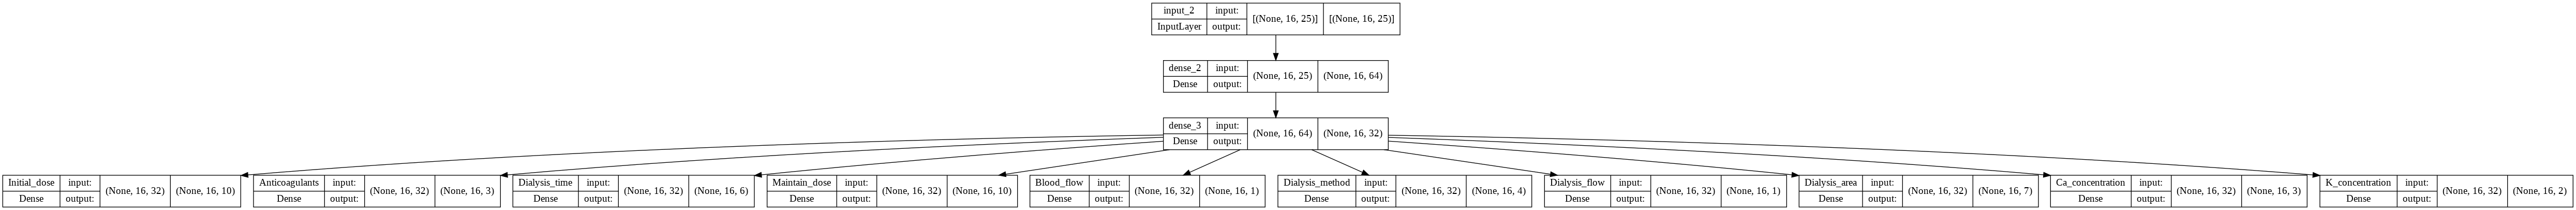

In [ ]:
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model.build_graph(features.shape),     
    to_file='model.png', dpi=96,               
    show_shapes=True, show_layer_names=True,  
    expand_nested=False                 
)

In [ ]:
loss_object_scc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object_mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  losses = 0
  y_ = model(x, training=training)
  for i in y_:
    if i == '血液流速' or i == '透析液流速':
      loss = loss_object_mse(y[i], y_[i])
    else:
      loss = loss_object_scc(y[i], y_[i])
    losses += loss
  return losses

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy1 = tf.keras.metrics.SparseCategoricalAccuracy()
  epoch_accuracy2 = tf.keras.metrics.SparseCategoricalAccuracy()
  # Training loop - using batches of 32
  for x, y in train:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    #print(loss_value)
    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    #epoch_accuracy1.update_state(y['透析方式'], model(x, training=True)['透析方式'])
    #epoch_accuracy2.update_state(y['鈣離子濃度'], model(x, training=True)['鈣離子濃度'])
    #print(epoch_accuracy1, epoch_accuracy2)
    #epoch_accuracy = np.mean([epoch_accuracy1,epoch_accuracy2])
  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  #train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.6f}".format(epoch, epoch_loss_avg.result()))  #, epoch_accuracy.result()))
                                  

Epoch 000: Loss: 320800.687500
Epoch 050: Loss: 1736.052734
Epoch 100: Loss: 1293.418335
Epoch 150: Loss: 1147.502808
Epoch 200: Loss: 928.359741


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_con_loss = tf.keras.metrics.Mean(name = 'train_con_loss')
train_cat_loss = tf.keras.metrics.Mean(name = 'train_cat_loss')
loss_func = {'categorical' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'continuous' : tf.keras.losses.MeanSquaredError()}

task_weight = [tf.Variable(1.0,trainable=True), tf.Variable(1.0, trainable=True)]
def train_batch(features, labels, weight):
  losses = []
  gnorms = []

  with tf.GradientTape() as tape:
    y_pred = model(features, training = True)
    for i in y_pred:
      if i == '血液流速' or i == '透析液流速':
        task_loss = loss_func['continuous'](labels[i], y_pred[i])
      else:
        task_loss = loss_func['categorical'](labels[i], y_pred[i])
      losses.append(tf.Variable(1.0, trainable=True)*task_loss)

    loss = tf.add_n(losses)
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)
  return loss, losses

for epoch in range(num_epochs):
  # Training loop - using batches of 32
  train_loss.reset_states()
  for x, y in train:
    # Optimize the model
    loss, losses = train_batch(x,y,task_weight)

  if epoch % 50 == 0:
    #print("Epoch {:03d}: Loss: {:.6f}".format(epoch, train_loss.result()))  #, epoch_accuracy.result()))
    print("Epoch {:03d}: Loss: {:.6f}".format(epoch, train_loss.result()))